In [1]:
!gdown --id '1-WZHD7fL8fCyQHAxxwnEmJJwH73kYua_&confirm=t' --output data.zip
!unzip data.zip
!ls 

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-WZHD7fL8fCyQHAxxwnEmJJwH73kYua_&confirm=t
To: /content/data.zip
100% 372M/372M [00:01<00:00, 238MB/s]
Archive:  data.zip
   creating: timit_11/
  inflating: timit_11/train_11.npy   
  inflating: timit_11/test_11.npy    
  inflating: timit_11/train_label_11.npy  
data.zip  sample_data  timit_11


In [2]:
!ls
!mkdir models
!ls

data.zip  sample_data  timit_11
data.zip  models  sample_data  timit_11


In [ ]:
import numpy as np
import gc

# load data
data = np.load('timit_11/train_11.npy')  # load training data
print(data.shape)  # (1229932, 429)
print(data.dtype)

label = np.load('timit_11/train_label_11.npy')  # load labels
print(label.shape)  # (1229932,)
print(label.dtype)
print(label[0])
print(label[90])

del data, label
gc.collect()

(1229932, 429)
float64
(1229932,)
<U2
36
35


22

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import gc

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)


# support gpu or not
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'


# split data into training data and validation data
def split_data(data, label):
    VAL_RATIO = 0.2

    percent = int(data.shape[0] * (1 - VAL_RATIO))
    train_data, train_label, val_data, val_label = data[:percent], label[:percent], data[percent:], label[percent:]
    print('Size of training set: {}'.format(train_data.shape))
    print('Size of validation set: {}'.format(val_data.shape))
    return train_data, train_label, val_data, val_label


# a custom Dataset, load data from .npy files
class VoiceDataset(Dataset):
    def __init__(self, data_train, data_label):
        super().__init__()
        self.data_train = torch.from_numpy(data_train).float()  # data for training
        self.data_label = torch.LongTensor(data_label.astype(np.int32))  # label for data used for training

    def __getitem__(self, index):
        return self.data_train[index], self.data_label[index]  # return a element in dataset according to index

    def __len__(self):
        return len(self.data_label)  # return the length of this dataset


class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super(NeuralNet, self).__init__()
        # define the network
        self.net = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.Sigmoid(),
            nn.Linear(1024, 512),
            nn.Sigmoid(),
            nn.Linear(512, 128),
            nn.Sigmoid(),
            nn.Linear(128, output_size),
        )

    def forward(self, input):
        # return the output of network
        return self.net(input)
    
    def cal_loss(self, pred, target):
        self.criterion = nn.CrossEntropyLoss()  # set loss function to Cross Entropy
        return self.criterion(pred, target)


# this function includes everything for training
def train(tr_set, dv_set, model, config, device):
    num_epochs = config['num_epochs']  # number of epochs

    # set the optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])
    
    # init parameters for epochs
    min_mse = 1000.  # set the initial value for min_mse (higher than the mse after first epoch)
    loss_record = {'train': [], 'dev': []}
    
    # epochs for trianing
    for epoch in range(num_epochs):
        model.train()  # set model to trian mode
        for i, (data, label) in enumerate(tr_set):
            optimizer.zero_grad()  # set gradient to zero before calculate
            data, label = data.to(device), label.to(device)  # move data to device
            pred = model(data)  # compute the predict from data
            loss = model.cal_loss(pred, label)  # compute the mse loss
            loss.backward()  # get the gradient
            optimizer.step()  # updata parameters in model
            loss_record['train'].append(loss.detach().cpu().item())

            # print training status every 100 optimisations
            if (i+1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, len(tr_set), loss.item()))

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break
    
    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record


# fuction to compute mse in validation
def dev(dv_set, model, device):
    model.eval()  # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:  # iterate through the dataloader
        x, y = x.to(device), y.to(device)  # move data to device (cpu/cuda)
        with torch.no_grad():  # disable gradient calculation
            pred = model(x)  # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)  # compute averaged loss

    return total_loss


# function for model test
def test(tt_set, model, device):
    model.eval()  # set model to evalutation mode
    preds = []

    for data in tt_set:
        data = data.to(device)
        # we don't need compute gradient when testing
        with torch.no_grad():
            pred = model(data)
            preds.append(pred.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
    return preds



# load data
data = np.load('timit_11/train_11.npy')  # load training data
print('size of dataset from train_11.npy: {}'.format(data.shape))  # (1229932, 429)

label = np.load('timit_11/train_label_11.npy')  # load labels
print('size of dataset from train_label_11.npy: {}'.format(label.shape))  # (1229932,)

device = get_device()
print('your device: {}'.format(device))

# parameters for training
config = {
    'num_epochs': 10,
    'batch_size': 270,
    'optimizer': 'SGD',  # optimizer algorithm
    'optim_hparas': {
        'lr': 0.001,  # learning rate
        'momentum': 0.9  # momentum for SGD
    },
    'save_path': 'models/model.pth',
    'early_stop': 200
}

# split data for training and validation
train_data, train_label, val_data, val_label = split_data(data=data, label=label)

train_set = VoiceDataset(train_data, train_label)  # dataset for training
train_loader = DataLoader(dataset=train_set, batch_size=config['batch_size'], shuffle=True)

val_set = VoiceDataset(val_data, val_label)
val_loader = DataLoader(dataset=val_set, batch_size=config['batch_size'], shuffle=False)

# delete the data loaded to save space
del data, label, train_data, train_label, val_data, val_label
gc.collect()

model = NeuralNet(429, 39).to(device)  # create network

min_mse, loss_record = train(train_loader, val_loader, model, config, device)

size of dataset from train_11.npy: (1229932, 429)
size of dataset from train_label_11.npy: (1229932,)
your device: cuda
Size of training set: (983945, 429)
Size of validation set: (245987, 429)
Epoch [1/10], Step [100/3645], Loss: 3.3730
Epoch [1/10], Step [200/3645], Loss: 3.3175
Epoch [1/10], Step [300/3645], Loss: 3.2632
Epoch [1/10], Step [400/3645], Loss: 3.2415
Epoch [1/10], Step [500/3645], Loss: 3.2773
Epoch [1/10], Step [600/3645], Loss: 3.2811
Epoch [1/10], Step [700/3645], Loss: 3.3957
Epoch [1/10], Step [800/3645], Loss: 3.2213
Epoch [1/10], Step [900/3645], Loss: 3.2584
Epoch [1/10], Step [1000/3645], Loss: 3.3027
Epoch [1/10], Step [1100/3645], Loss: 3.3683
Epoch [1/10], Step [1200/3645], Loss: 3.2978
Epoch [1/10], Step [1300/3645], Loss: 3.2756
Epoch [1/10], Step [1400/3645], Loss: 3.2509
Epoch [1/10], Step [1500/3645], Loss: 3.2471
Epoch [1/10], Step [1600/3645], Loss: 3.1940
Epoch [1/10], Step [1700/3645], Loss: 3.2667
Epoch [1/10], Step [1800/3645], Loss: 3.3257
Epoch

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

2.1738587954396493


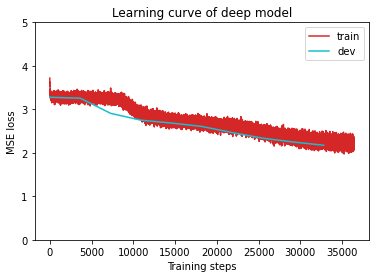

In [7]:
print(min_mse)
plot_learning_curve(loss_record, title='deep model')